In [1]:
# !pip install pennylane koreanize_matplotlib -q
import torch
import torch.nn as nn
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
plt.rcParams['axes.unicode_minus'] = False

from IPython.display import clear_output
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
epochs   = 100
lr       = 0.01   # 학습률: 0.001 / 0.01 / 0.1
# ===== 수정 끝 =====
# ============================================================

# --- 데이터 생성 ---
x1 = std_np.array([2*i + 1   for i in range(50)], dtype=float)
x2 = std_np.array([2*(i + 1) for i in range(50)], dtype=float)
y  = x1 * x2   # label: 2, 12, 30, ..., 9900
THEORY_SUM = 169150

print("--- 데이터 확인 ---")
print(f"  x1[:5] = {x1[:5]}")
print(f"  x2[:5] = {x2[:5]}")
print(f"  y[:5]  = {y[:5]}")
print(f"  y 범위: {y.min():.0f} ~ {y.max():.0f}")
print(f"  이론 총합 = {y.sum():.0f}")

# --- 스케일링 ---
def scale_x(x):
    return (x - 1) / 99 * std_np.pi

Y_MIN, Y_MAX = 2.0, 9900.0

def scale_y(y_val):
    return (y_val - Y_MIN) / (Y_MAX - Y_MIN)

def unscale_y(y_scaled):
    return y_scaled * (Y_MAX - Y_MIN) + Y_MIN

x1_sc = scale_x(x1)
x2_sc = scale_x(x2)
y_sc  = scale_y(y)

# --- train / test 분할 ---
std_np.random.seed(42)
idx       = std_np.random.permutation(50)
n_train   = 35
idx_train = idx[:n_train]
idx_test  = idx[n_train:]
print(f"\n  train: {n_train}개, test: {len(idx_test)}개 (셔플)")

# ===========================================================
#  lab5: MLP 고전 신경망 회귀
# ===========================================================

print("\n" + "=" * 60)
print("lab5: MLP (고전 신경망 회귀)")
print("=" * 60)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 3),nn.Tanh(),
                    nn.Linear(3, 1), nn.Sigmoid() )  # 출력 [0, 1]
    def forward(self, x):
        return self.net(x).squeeze()

# 데이터 tensor 변환
X_train_t = torch.tensor(std_np.column_stack([x1_sc[idx_train], 
                                              x2_sc[idx_train]]),
                          dtype=torch.float32)
y_train_t = torch.tensor(y_sc[idx_train], dtype=torch.float32)
X_all_t   = torch.tensor(std_np.column_stack([x1_sc, x2_sc]),
                          dtype=torch.float32)

# 학습
torch.manual_seed(42)
model     = MLP()
opt_mlp   = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
n_params  = sum(p.numel() for p in model.parameters())

print(f"  MLP 구조: 2 -> 3 -> 1  (Tanh + Sigmoid)")
print(f"  파라미터 수: {n_params}")
print(f"  epochs={epochs}, lr={lr}")

--- 데이터 확인 ---
  x1[:5] = [1. 3. 5. 7. 9.]
  x2[:5] = [ 2.  4.  6.  8. 10.]
  y[:5]  = [ 2. 12. 30. 56. 90.]
  y 범위: 2 ~ 9900
  이론 총합 = 169150

  train: 35개, test: 15개 (셔플)

lab5: MLP (고전 신경망 회귀)
  MLP 구조: 2 -> 3 -> 1  (Tanh + Sigmoid)
  파라미터 수: 13
  epochs=100, lr=0.01


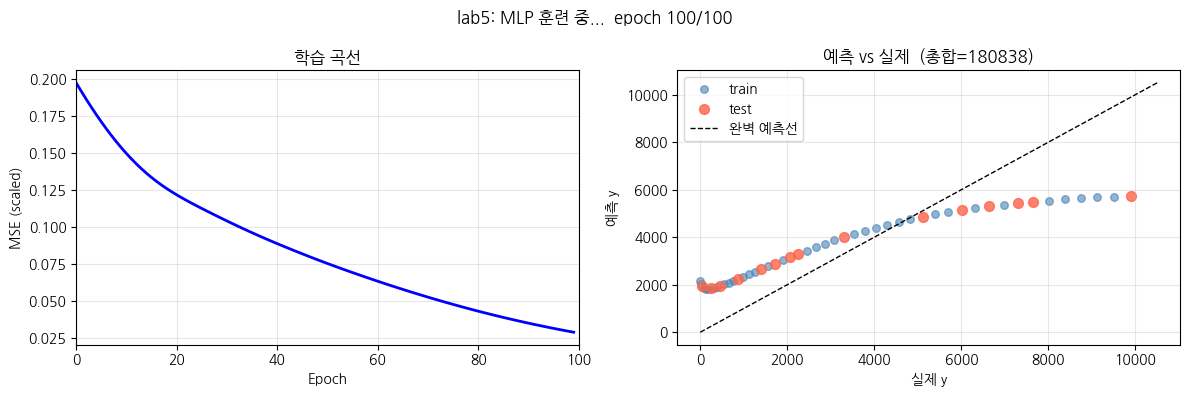

In [2]:
mlp_history = []
for ep in range(epochs):
    opt_mlp.zero_grad()
    pred = model(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    opt_mlp.step()
    mlp_history.append(loss.item())

    if ep % 5 == 0 or ep == epochs - 1:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"lab5: MLP 훈련 중...  epoch {ep+1}/{epochs}", fontsize=12)

        # 왼쪽: 학습 곡선
        ax1.plot(mlp_history, 'b-', lw=2)
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("MSE (scaled)")
        ax1.set_title("학습 곡선")
        ax1.set_xlim(0, epochs)
        ax1.grid(True, alpha=0.3)

        # 오른쪽: 예측 vs 실제 (실시간)
        with torch.no_grad():
            preds_sc = model(X_all_t).numpy()
        preds_now = preds_sc * (Y_MAX - Y_MIN) + Y_MIN
        ax2.scatter(y[idx_train], preds_now[idx_train],
                    c='steelblue', alpha=0.6, s=30, label='train')
        ax2.scatter(y[idx_test],  preds_now[idx_test],
                    c='tomato',    alpha=0.8, s=50, label='test')
        ax2.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')
        ax2.set_xlabel("실제 y"); ax2.set_ylabel("예측 y")
        ax2.set_title(f"예측 vs 실제  (총합={preds_now.sum():.0f})")
        ax2.legend(); ax2.grid(True, alpha=0.3)

        plt.tight_layout(); plt.show()

In [3]:
# 예측
with torch.no_grad():
    mlp_preds_sc = model(X_all_t).numpy()
mlp_preds = mlp_preds_sc * (Y_MAX - Y_MIN) + Y_MIN
mlp_sum   = mlp_preds.sum()

mlp_test_mse = std_np.mean((mlp_preds[idx_test] - y[idx_test]) ** 2)
print(f"\n  MLP 총합:  {mlp_sum:.1f}  (이론: {THEORY_SUM})")
print(f"  test MSE:  {mlp_test_mse:.2f}")

print("\nlab5 완료!")


  MLP 총합:  180838.0  (이론: 169150)
  test MSE:  2942343.58

lab5 완료!
